In [1]:
import os
import re

from datetime import datetime

import torch
import numpy as np
import pandas as pd

import wfdb
from scipy import sparse
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt
# plt.style.use('dark_background')

import multiprocessing

### Create numpy memory-map file

In [2]:
# import ecg details
ecg_path = '/home/oturgut/data/mimic-iv-ecg/1.0/'
ecg_detail = pd.read_csv(ecg_path+'record_list.csv')
print(len(ecg_detail))
ecg_detail[:10]

800035


,subject_id,study_id,file_name,ecg_time,path
0,10000032,40689238,40689238,2180-07-23 08:44:00,files/p1000/p10000032/s40689238/40689238
1,10000032,44458630,44458630,2180-07-23 09:54:00,files/p1000/p10000032/s44458630/44458630
2,10000032,49036311,49036311,2180-08-06 09:07:00,files/p1000/p10000032/s49036311/49036311
3,10000117,45090959,45090959,2181-03-04 17:14:00,files/p1000/p10000117/s45090959/45090959
4,10000117,48446569,48446569,2183-09-18 13:52:00,files/p1000/p10000117/s48446569/48446569
5,10000285,42709053,42709053,2159-11-26 14:29:00,files/p1000/p10000285/s42709053/42709053
6,10000560,41445586,41445586,2189-10-03 12:54:00,files/p1000/p10000560/s41445586/41445586
7,10000560,42695383,42695383,2198-09-19 10:01:00,files/p1000/p10000560/s42695383/42695383
8,10000635,40067704,40067704,2136-06-19 07:24:00,files/p1000/p10000635/s40067704/40067704
9,10000635,48339811,48339811,2136-06-20 08:54:00,files/p1000/p10000635/s48339811/48339811


In [3]:
# check number of unique ecg subjects
ecg_subjects = ecg_detail["subject_id"].unique()
print(len(ecg_subjects))

161352


In [13]:
torch.save(ecg_detail["path"].values, "/home/oturgut/data/processed/mimic-ecg-text/ecgs_file_path.pt")

In [16]:
fp = np.memmap("/home/oturgut/data/processed/mimic-ecg-text/ecgs_memmap.dat", dtype='float32', mode='r+', shape=(800035, 12, 5000))

In [ ]:
def process_ecgs(sample_id):
    file_name = ecg_detail.loc[sample_id, "path"]
    rec_path = ecg_path+file_name

    data = wfdb.rdsamp(rec_path, return_res=32)[0]
    data = np.transpose(data)

    # remove nan
    data = np.nan_to_num(data)
    
    # clamp
    data_std = data.std()
    data = np.clip(data, a_min=-4*data_std, a_max=4*data_std)

    # remove baseline wander
    baselines = np.zeros_like(data)
    for lead in range(data.shape[0]):
        baselines[lead] = baseline_als(data[lead], lam=1e7, p=0.3, niter=5)
    data = data - baselines

    # normalize data
    transform = Normalization(mode="group_wise", groups=[3, 6, 12])
    data = transform(data)

    return data, rec_path


if __name__ == '__main__':
    # Define the number of processes
    num_processes = 16

    ecgs = []
    # Create a multiprocessing Pool
    with multiprocessing.Pool(processes=num_processes) as pool:
        results = pool.map(process_ecgs, range(1000))
        
    # extract results into separate lists
    ecgs, rec_paths = zip(*results)

    print(len(ecgs))

    # tensor_ecg = torch.tensor(np.array(ecgs))
    fp[:1000] = np.array(ecgs)
    fp.flush()

    # print(tensor_ecg.shape, tensor_ecg.dtype)

In [ ]:
fp[0]

memmap([[-0.07189263, -0.21425413, -0.21940723, ..., -0.09712695,
         -0.18788548, -0.3701162 ],
        [-0.03344372, -0.03258858, -0.12320559, ..., -0.556074  ,
         -0.6485588 , -0.74104345],
        [-0.1880078 , -0.0447662 , -0.1302049 , ..., -0.6365034 ,
         -0.6380154 , -0.54805535],
        ...,
        [-0.05338173, -0.10013048, -0.12383203, ..., -0.5661242 ,
         -0.56283814, -0.55955213],
        [-0.00649234, -0.00492439, -0.00335645, ..., -0.47528172,
         -0.47116256, -0.46704334],
        [-0.22276278, -0.22311199, -0.2695556 , ..., -0.30344695,
         -0.2930371 , -0.28262725]], dtype=float32)

In [2]:
fp2 = np.memmap("/home/oturgut/data/processed/mimic-ecg-text/ecgs_memmap.dat", dtype='float32', mode='r', shape=(800035, 12, 5000))

In [4]:
fp2[800034].shape

(12, 5000)

In [ ]:
# torch.save(tensor_ecg, "/home/oturgut/data/processed/mimic-ecg-text/ecgs.pt")

In [ ]:
len(rec_paths)

5000

In [ ]:
rec_paths[:10]

('/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000032/s40689238/40689238',
 '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000032/s44458630/44458630',
 '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000032/s49036311/49036311',
 '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000117/s45090959/45090959',
 '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000117/s48446569/48446569',
 '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000285/s42709053/42709053',
 '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000560/s41445586/41445586',
 '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000560/s42695383/42695383',
 '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000635/s40067704/40067704',
 '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000635/s48339811/48339811')

In [ ]:
# torch.save(tensor_ecg, "/home/oturgut/data/processed/mimic-ecg-text/ecgs_10k.pt")

## ECG DATA

In [ ]:
# import ecg details
ecg_path = '/home/oturgut/data/mimic-iv-ecg/1.0/'
ecg_detail = pd.read_csv(ecg_path+'waveform_note_links.csv')
print(len(ecg_detail))
ecg_detail[:10]

609272


,subject_id,study_id,waveform_path,note_id,note_seq,charttime
0,10000032,40689238,files/p1000/p10000032/s40689238/40689238,10000032-EK-4,4,2180-07-23 08:44:00
1,10000032,44458630,files/p1000/p10000032/s44458630/44458630,10000032-EK-5,5,2180-07-23 09:54:00
2,10000032,49036311,files/p1000/p10000032/s49036311/49036311,10000032-EK-6,6,2180-08-06 09:07:00
3,10000117,48446569,files/p1000/p10000117/s48446569/48446569,10000117-EK-17,17,2183-09-18 13:52:00
4,10000560,41445586,files/p1000/p10000560/s41445586/41445586,10000560-EK-12,12,2189-10-03 12:54:00
5,10000635,40067704,files/p1000/p10000635/s40067704/40067704,10000635-EK-12,12,2136-06-19 07:24:00
6,10000635,48339811,files/p1000/p10000635/s48339811/48339811,10000635-EK-13,13,2136-06-20 08:54:00
7,10000635,45386375,files/p1000/p10000635/s45386375/45386375,10000635-EK-14,14,2136-07-05 12:35:00
8,10000635,43522917,files/p1000/p10000635/s43522917/43522917,10000635-EK-15,15,2137-02-07 13:58:00
9,10000635,44095784,files/p1000/p10000635/s44095784/44095784,10000635-EK-16,16,2138-09-29 11:09:00


In [ ]:
# check number of unique ecg subjects
ecg_subjects = ecg_detail["subject_id"].unique()
print(len(ecg_subjects))

105293


#### Pre-processing

In [ ]:
class Normalization(object):
    """
    Normalize the data.
    """
    def __init__(self, mode="sample_wise", groups=[3, 6, 12]) -> None:
        self.mode = mode
        self.groups = groups

    def __call__(self, sample) -> np.array:
        sample_dtype = sample.dtype

        if self.mode == "sample_wise":
            mean = np.mean(sample)
            var = np.var(sample)
        
        elif self.mode == "channel_wise":
            mean = np.mean(sample, axis=-1, keepdims=True)
            var = np.var(sample, axis=-1, keepdims=True)
        
        elif self.mode == "group_wise":
            mean = []
            var = []

            lower_bound = 0
            for idx in self.groups:
                mean_group = np.mean(sample[lower_bound:idx], axis=(0, 1), keepdims=True)
                mean_group = np.repeat(mean_group, repeats=int(idx-lower_bound), axis=0)
                var_group = np.var(sample[lower_bound:idx], axis=(0, 1), keepdims=True)
                var_group = np.repeat(var_group, repeats=int(idx-lower_bound), axis=0)
                lower_bound = idx

                mean.extend(mean_group)
                var.extend(var_group)

            mean = np.array(mean, dtype=sample_dtype)
            var = np.array(var, dtype=sample_dtype)

        normalized_sample = (sample - mean) / (var + 1.e-5)**.5

        return normalized_sample
    

def baseline_als(y, lam=1e8, p=1e-2, niter=10):
    """
    Paul H. C. Eilers and Hans F.M. Boelens: Baseline Correction with Asymmetric Least Squares Smoothing
    https://www.rdocumentation.org/packages/baseline/versions/1.3-1/topics/baseline.als
    """
    L = len(y)
    D = sparse.diags([1,-2,1], [0,-1,-2], shape=(L, L-2))
    D = lam * D.dot(D.transpose())
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w)
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

(12, 5000)
BASELINE WANDER REMOVAL
GROUP NORMALIZATION


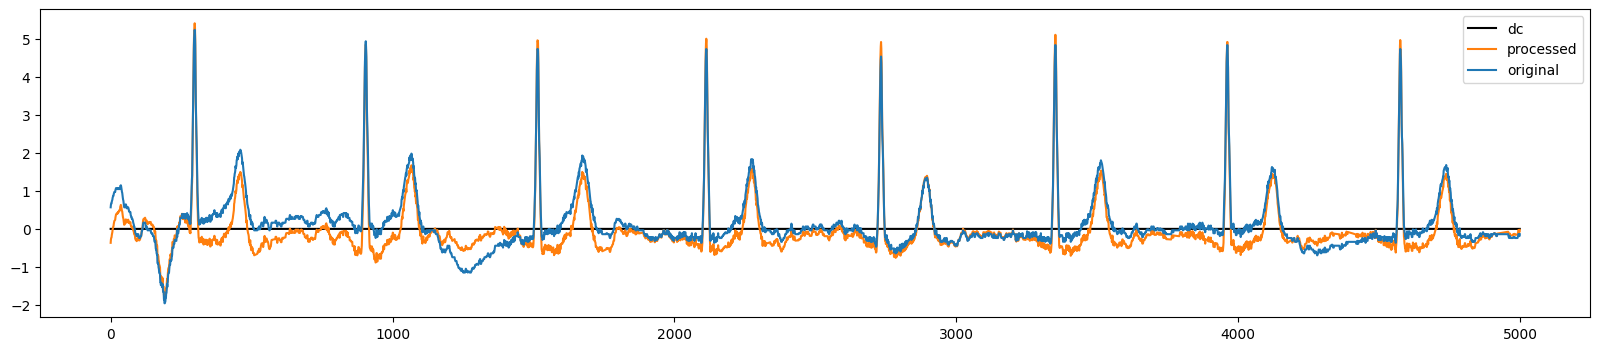

In [ ]:
# visualize preprocessing

# rec_path = '/home/oturgut/data/mimic-iv-ecg/1.0/files/p1000/p10000764/s44069449/44069449'
# rec_path = "/home/oturgut/data/mimic-iv-ecg/1.0/files/p1447/p14474896/s46823076/46823076"
# rec_path = "/home/oturgut/data/mimic-iv-ecg/1.0/files/p1951/p19513389/s41757975/41757975"
# rec_path = "/home/oturgut/data/mimic-iv-ecg/1.0/files/p1263/p12633462/s43404535/43404535"
rec_path = "/home/oturgut/data/mimic-iv-ecg/1.0/files/p1159/p11593664/s45534050/45534050"

data = wfdb.rdsamp(rec_path, return_res=16)[0]
data = np.transpose(data)
ecg_data = data
print(data.shape)

# remove baseline wander
print("BASELINE WANDER REMOVAL")
baselines = np.zeros_like(data)

for lead in range(data.shape[0]):
    baselines[lead] = baseline_als(data[lead], lam=1e7, p=0.3, niter=5)

data = data - baselines

# normalize data
print("GROUP NORMALIZATION")
transform = Normalization(mode="group_wise", groups=[3, 6, 12])
data = transform(data)
ecg_data = transform(ecg_data)

# plot data
lead = 11
plt.figure(figsize=(20, 4))
plt.plot(np.zeros(5000), color='black', label='dc')
plt.plot(data[lead], color='tab:orange', label='processed')
plt.plot(ecg_data[lead], color='tab:blue', label='original')
plt.legend()
plt.show()

In [ ]:
def process_ecgs(sample_id):
    file_name = ecg_detail.loc[sample_id, "waveform_path"]
    rec_path = ecg_path+file_name

    data = wfdb.rdsamp(rec_path, return_res=32)[0]
    data = np.transpose(data)

    # remove nan
    data = np.nan_to_num(data)
    
    # clamp
    data_std = data.std()
    data = np.clip(data, a_min=-4*data_std, a_max=4*data_std)

    # remove baseline wander
    baselines = np.zeros_like(data)
    for lead in range(data.shape[0]):
        baselines[lead] = baseline_als(data[lead], lam=1e7, p=0.3, niter=5)
    data = data - baselines

    # normalize data
    transform = Normalization(mode="group_wise", groups=[3, 6, 12])
    data = transform(data)

    return data


if __name__ == '__main__':
    # Define the number of processes
    num_processes = 32

    ecgs = []
    # Create a multiprocessing Pool
    with multiprocessing.Pool(processes=num_processes) as pool:
        ecgs.extend(pool.map(process_ecgs, range(250000)))
        
    print(len(ecgs))

    tensor_ecg = torch.tensor(np.array(ecgs))

    print(tensor_ecg.shape, tensor_ecg.dtype)

In [ ]:
# torch.save(torch.tensor(np.array(ecgs), dtype=torch.float16), '/home/oturgut/data/processed/mimic-ecg-text/ecg_pretrain_250k_float16.pt')

In [ ]:
# torch.save(ecg_note_ids[:2048], '/home/oturgut/data/processed/mimic-ecg-text/ecg_test_note_ids.pt')
# torch.save(torch.tensor(ecgs), '/home/oturgut/data/processed/mimic-ecg-text/ecg_test.pt')

In [ ]:
ukbb_ecgs = torch.load("/home/oturgut/sprai/data/preprocessed/ecg/ecgsRaw/ecgs_val_ecg_imaging.pt")
ukbb_ecgs.shape

torch.Size([6007, 12, 5000])

In [ ]:
ukbb_ecgs_old = torch.load("/home/oturgut/sprai/data/preprocessed/ecg/ecgs_val_ecg_imaging_noBase_gn.pt")
ukbb_ecgs.shape

(6007, 12, 5000)

In [ ]:
def process_ukbb_ecgs(data):
    # remove nan
    data = np.nan_to_num(data)
    
    # clamp
    data_std = data.std()
    data = np.clip(data, a_min=-4*data_std, a_max=4*data_std)

    # remove baseline wander
    baselines = np.zeros_like(data)
    for lead in range(data.shape[0]):
        baselines[lead] = baseline_als(data[lead], lam=1e7, p=0.3, niter=5)
    data = data - baselines

    # normalize data
    transform = Normalization(mode="group_wise", groups=[3, 6, 12])
    data = transform(data)

    return data


if __name__ == "__main__":
    # Define the number of processes
    num_processes = 32

    ukbb_ecgs = ukbb_ecgs.numpy()
    ukbb_ecgs_processed = []

    # Create a multiprocessing Pool
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Map the function to each process and concatenate the results
        ukbb_ecgs_processed.extend(pool.map(process_ukbb_ecgs, ukbb_ecgs))

    ukbb_ecgs_processed = torch.tensor(np.array(ukbb_ecgs_processed), dtype=torch.float32)

    print(ukbb_ecgs_processed.shape)

torch.Size([6007, 12, 5000])


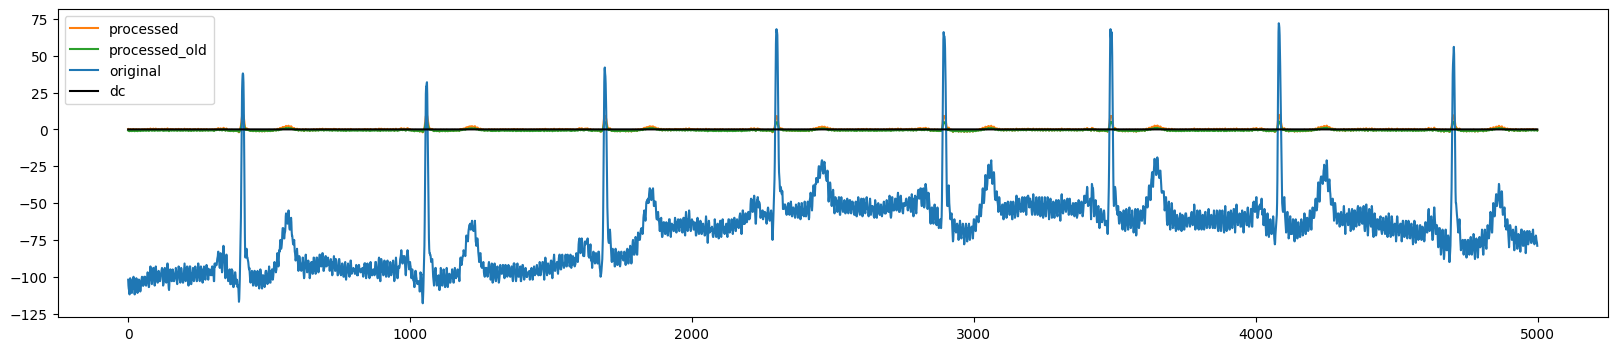

In [ ]:
subject = 2555
channel = 5

plt.figure(figsize=(20, 4))
plt.plot(ukbb_ecgs_processed[subject, channel], color='tab:orange', label='processed')
plt.plot(ukbb_ecgs_old[subject, channel], color='tab:green', label='processed_old')
plt.plot(ukbb_ecgs[subject, channel], color='tab:blue', label='original')
plt.plot(np.zeros(5000), color='black', label='dc')
plt.legend()
plt.show()

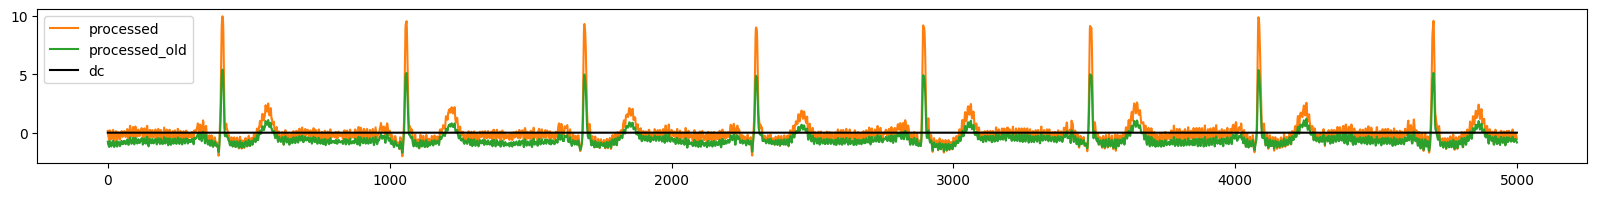

In [ ]:
subject = 2555
channel = 5

plt.figure(figsize=(20, 2))
plt.plot(ukbb_ecgs_processed[subject, channel], color='tab:orange', label='processed')
plt.plot(ukbb_ecgs_old[subject, channel], color='tab:green', label='processed_old')
plt.plot(np.zeros(5000), color='black', label='dc')
plt.legend()
plt.show()

In [ ]:
# torch.save(ukbb_ecgs_processed, '/home/oturgut/sprai/data/preprocessed/ecg/ukbb_ecgs_val_ecg_imaging_float32.pt')

## TEXT DATA

### Radiology

In [ ]:
# load radiology details (this is not the dataset, only headers)
radiology_detail = pd.read_csv('/home/oturgut/data/mimic-iv-note/2.2/note/radiology_detail.csv.gz', compression='gzip')
print(len(radiology_detail))
radiology_detail[:10]

6046121


,note_id,subject_id,field_name,field_value,field_ordinal
0,10000032-RR-14,10000032,exam_code,C11,1
1,10000032-RR-14,10000032,exam_name,CHEST (PA & LAT),1
2,10000032-RR-15,10000032,exam_code,U314,1
3,10000032-RR-15,10000032,exam_code,U644,3
4,10000032-RR-15,10000032,exam_code,W82,2
5,10000032-RR-15,10000032,exam_name,-59 DISTINCT PROCEDURAL SERVICE,2
6,10000032-RR-15,10000032,exam_name,DUPLEX DOP ABD/PEL LIMITED,3
7,10000032-RR-15,10000032,exam_name,LIVER OR GALLBLADDER US (SINGLE ORGAN),1
8,10000032-RR-16,10000032,exam_code,U321,1
9,10000032-RR-16,10000032,exam_name,PARACENTESIS DIAG/THERAP W IMAGING GUID,1


In [ ]:
# load entire radiology dataset
radiology_data = pd.read_csv('/home/oturgut/data/mimic-iv-note/2.2/note/radiology.csv.gz', compression='gzip')

In [ ]:
# check number of unique radiology subjects
radiology_subjects = radiology_data["subject_id"].unique()
radiology_subjects.shape

(237427,)

In [ ]:
# determine the set of subjects that have paired ecg and radiology data 
overlapping_subjects = []
for idx, subj in enumerate(ecg_subjects[:]):
    if subj in radiology_subjects:
        overlapping_subjects.append(subj)

overlapping_subject_ids = np.array(overlapping_subjects)
print(overlapping_subject_ids.shape)

(100741,)


#### Parsing

In [ ]:
radiology_note_ids = torch.load("/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_note_id.pt")

In [ ]:
# show exemplary report
report_id = 2000
txt = radiology_data['text'][report_id]
print(txt)

INDICATION:  Productive cough and intermittent shortness of breath.

COMPARISON:  None.

PA AND LATERAL VIEWS OF THE CHEST:  The cardiac, mediastinal and hilar
contours are normal.  The lungs are clear.  No pleural effusion or
pneumothorax is present.  There are no acute osseous findings.

IMPRESSION:  No acute cardiopulmonary process.



In [ ]:
# parse the FINDINGS and IMPRESSION sections
def extract_sections(report_text):
    # Define patterns for FINDINGS and IMPRESSION sections
    findings_pattern = re.compile(r'FINDINGS:(.*?)(IMPRESSION:|$)', re.DOTALL)
    impression_pattern = re.compile(r'IMPRESSION:(.*?)(?=$|\Z)', re.DOTALL)

    # Find matches for FINDINGS and IMPRESSION sections
    findings_match = findings_pattern.search(report_text)
    impression_match = impression_pattern.search(report_text)

    # Extract text from the matched groups, handling missing sections
    findings_text = findings_match.group(1).strip().replace('\n', ' ') if findings_match else None
    impression_text = impression_match.group(1).strip().replace('\n', ' ') if impression_match else None

    # Remove underscores
    if findings_text:
        findings_text = ' '.join(findings_text.replace('_', '').split())
    if impression_text:
        impression_text = ' '.join(impression_text.replace('_', '').split())

    # Split the sections into sentences, considering numerical listings
    findings_sentences = re.split(r'(?<!\d\.)(?<=\.|\?)\s', findings_text) if findings_text else []
    impression_sentences = re.split(r'(?<!\d\.)(?<=\.|\?)\s', impression_text) if impression_text else []

    return findings_sentences, impression_sentences

In [ ]:
findings, impression = extract_sections(txt)
print(findings)
print(impression)

['Compared with , I doubt significant interval change.', 'Again seen is asymmetric pleural thickening at the right lung apex, with apparent retraction of the minor fissure.', 'The cardiomediastinal silhouette is unchanged.', 'There is probably very slight upper zone redistribution, but I doubt overt CHF.', 'Possible minimal blunting of the right costophrenic angle, which is not clearly changed.', 'No focal consolidation or gross effusion is identified.', 'The cardiomediastinal silhouette is borderline enlarged with a calcified slightly unfolded aorta, but is unchanged.', 'Incidental note is made of a probable large subchondral cyst in the left glenoid.']
['No significant change detected compared with .', 'Right apical pleural thickening, with apparent retraction of the mild fissure, again noted.', 'Upper zone redistribution and minimal blunting of the right costophrenic angle are probably unchanged, allowing for technical differences.']


In [ ]:
findings

['Compared with , I doubt significant interval change.',
 'Again seen is asymmetric pleural thickening at the right lung apex, with apparent retraction of the minor fissure.',
 'The cardiomediastinal silhouette is unchanged.',
 'There is probably very slight upper zone redistribution, but I doubt overt CHF.',
 'Possible minimal blunting of the right costophrenic angle, which is not clearly changed.',
 'No focal consolidation or gross effusion is identified.',
 'The cardiomediastinal silhouette is borderline enlarged with a calcified slightly unfolded aorta, but is unchanged.',
 'Incidental note is made of a probable large subchondral cyst in the left glenoid.']

In [ ]:
impression

['No significant change detected compared with .',
 'Right apical pleural thickening, with apparent retraction of the mild fissure, again noted.',
 'Upper zone redistribution and minimal blunting of the right costophrenic angle are probably unchanged, allowing for technical differences.']

In [ ]:
def extract_sections(report_text):
    # Define patterns for FINDINGS and IMPRESSION sections
    findings_pattern = re.compile(r'FINDINGS:(.*?)(IMPRESSION:|$)', re.DOTALL)
    impression_pattern = re.compile(r'IMPRESSION:(.*?)(?=$|\Z)', re.DOTALL)

    # Find matches for FINDINGS and IMPRESSION sections
    findings_match = findings_pattern.search(report_text)
    impression_match = impression_pattern.search(report_text)

    # Extract text from the matched groups, handling missing sections
    findings_text = findings_match.group(1).strip().replace('\n', ' ') if findings_match else None
    impression_text = impression_match.group(1).strip().replace('\n', ' ') if impression_match else None

    # Remove underscores
    if findings_text:
        findings_text = ' '.join(findings_text.replace('_', '').split())
    if impression_text:
        impression_text = ' '.join(impression_text.replace('_', '').split())

    # Split the sections into sentences, considering numerical listings
    findings_sentences = re.split(r'(?<!\d\.)(?<=\.|\?)\s', findings_text) if findings_text else []
    impression_sentences = re.split(r'(?<!\d\.)(?<=\.|\?)\s', impression_text) if impression_text else []

    return findings_sentences, impression_sentences

In [ ]:
subj = 2000
print(radiology_data[radiology_data["note_id"] == radiology_note_ids[subj]]["text"].values[0])

EXAMINATION:  PELVIS U.S., TRANSVAGINAL

INDICATION:  History: ___ with 5 weeks of vaginal bleeding soaking through 1
pads per 2 hours.// ?fibroid, mass or cause of bleed

Perimenopausal.

TECHNIQUE:  Grayscale ultrasound images of the pelvis were obtained with
transabdominal approach followed by transvaginal approach for further
delineation of uterine and ovarian anatomy.

COMPARISON:  CT of the abdomen pelvis from ___

FINDINGS: 

The uterus is anteverted and measures 10 x 5.8 x 8.2 cm. The endometrium is
homogenous and measures 5 mm.  Myometrium is heterogeneous with peripheral
cystic spaces.

The ovaries are normal. There is no free fluid.

IMPRESSION:


1. Findings may suggest adenomyosis.  If confirmation is required, MRI could
be obtained.
2. Normal endometrium.  No definite fibroid.
3. Normal ovaries.



In [ ]:
findings, impression = extract_sections(radiology_data[radiology_data["note_id"] == radiology_note_ids[subj]]['text'].values[0])
display(findings)
display(impression)

['The uterus is anteverted and measures 10 x 5.8 x 8.2 cm.',
 'The endometrium is homogenous and measures 5 mm.',
 'Myometrium is heterogeneous with peripheral cystic spaces.',
 'The ovaries are normal.',
 'There is no free fluid.']

['1. Findings may suggest adenomyosis.',
 'If confirmation is required, MRI could be obtained.',
 '2. Normal endometrium.',
 'No definite fibroid.',
 '3. Normal ovaries.']

## CREATE DATASET

#### Example

In [ ]:
print(f"Nb of total subjects: {len(overlapping_subject_ids)}\n")

subj = 0
print(f"Subject {overlapping_subject_ids[subj]}")
print(f"Nb of ECGs: {len(ecg_detail[ecg_detail['subject_id']==overlapping_subject_ids[subj]])}")
print(f"Nb of reports: {len(radiology_data[radiology_data['subject_id']==overlapping_subject_ids[subj]])}")

Nb of total subjects: 100741

Subject 10000032
Nb of ECGs: 3
Nb of reports: 24


In [ ]:
print(len(ecg_detail))
ecg_df = ecg_detail[ecg_detail['subject_id']==overlapping_subject_ids[subj]]
ecg_df

609272


,subject_id,study_id,waveform_path,note_id,note_seq,charttime
0,10000032,40689238,files/p1000/p10000032/s40689238/40689238,10000032-EK-4,4,2180-07-23 08:44:00
1,10000032,44458630,files/p1000/p10000032/s44458630/44458630,10000032-EK-5,5,2180-07-23 09:54:00
2,10000032,49036311,files/p1000/p10000032/s49036311/49036311,10000032-EK-6,6,2180-08-06 09:07:00


In [ ]:
print(len(radiology_data))
report_df = radiology_data[radiology_data["subject_id"]==overlapping_subject_ids[subj]]
report_df

2321355


,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-RR-14,10000032,22595853.0,RR,14,2180-05-06 21:19:00,2180-05-06 23:32:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
1,10000032-RR-15,10000032,22595853.0,RR,15,2180-05-06 23:00:00,2180-05-06 23:26:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
2,10000032-RR-16,10000032,22595853.0,RR,16,2180-05-07 09:55:00,2180-05-07 11:15:00,"INDICATION: ___ HCV cirrhosis c/b ascites, hi..."
3,10000032-RR-18,10000032,NaN,RR,18,2180-06-03 12:46:00,2180-06-03 14:01:00,EXAMINATION: Ultrasound-guided paracentesis.\...
4,10000032-RR-20,10000032,NaN,RR,20,2180-07-08 13:18:00,2180-07-08 14:15:00,EXAMINATION: Paracentesis\n\nINDICATION: ___...
5,10000032-RR-21,10000032,NaN,RR,21,2180-06-30 08:16:00,2180-06-30 12:58:00,EXAMINATION: ULTRASOUND INTERVENTIONAL PROCED...
6,10000032-RR-22,10000032,22841357.0,RR,22,2180-06-26 17:15:00,2180-06-26 19:28:00,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...
7,10000032-RR-23,10000032,22841357.0,RR,23,2180-06-26 17:17:00,2180-06-26 17:28:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
8,10000032-RR-24,10000032,NaN,RR,24,2180-07-22 12:40:00,2180-07-22 18:33:00,EXAMINATION: Ultrasound-guided paracentesis.\...
9,10000032-RR-27,10000032,NaN,RR,27,2180-07-12 13:35:00,2180-07-12 17:29:00,EXAMINATION: Ultrasound-guided paracentesis.\...


In [ ]:
report_note_ids = []
for ecg in ecg_df.iloc:
    ecg_date = datetime.strptime(ecg["charttime"], '%Y-%m-%d %H:%M:%S')

    report_note_id = None
    best_diff = np.inf
    for report in report_df.iloc:
        report_date = datetime.strptime(report["charttime"], '%Y-%m-%d %H:%M:%S')
        
        curr_diff = abs(ecg_date-report_date).total_seconds()
        if curr_diff < best_diff:
            best_diff = curr_diff
            report_note_id = report["note_id"]
    
    report_note_ids.append(report_note_id)

print(report_note_ids)

['10000032-RR-45', '10000032-RR-45', '10000032-RR-47']


In [ ]:
print(radiology_data[radiology_data["note_id"]==report_note_ids[2]]["text"].values[0])

#### Create pairs of ECG and report data

In [ ]:
def process_subject(subject):
    ecg_note_ids = []
    report_note_ids = []
    
    ecg_df = ecg_detail[ecg_detail['subject_id'] == subject]
    report_df = radiology_data[radiology_data["subject_id"] == subject]

    for ecg in ecg_df.iloc:
        ecg_date = datetime.strptime(ecg["charttime"], '%Y-%m-%d %H:%M:%S')

        report_note_id = None
        best_diff = np.inf
        for report in report_df.iloc:
            report_date = datetime.strptime(report["charttime"], '%Y-%m-%d %H:%M:%S')
            
            curr_diff = abs(ecg_date - report_date).total_seconds()
            if curr_diff < best_diff:
                best_diff = curr_diff
                report_note_id = report["note_id"]

        ecg_note_ids.append(ecg["note_id"])
        report_note_ids.append(report_note_id)

    return ecg_note_ids, report_note_ids

if __name__ == '__main__':
    # Define the number of processes
    num_processes = 32

    # Create a multiprocessing Pool
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Map the function to each process and concatenate the results
        results = pool.map(process_subject, overlapping_subject_ids)

    # Concatenate the results from each process
    ecg_note_ids = [item for sublist in results for item in sublist[0]]
    report_note_ids = [item for sublist in results for item in sublist[1]]

    print(len(ecg_note_ids), len(report_note_ids))


599889 599889


#### Create report dataset

In [ ]:
report_note_ids = torch.load("/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_note_id.pt")

In [ ]:
def extract_sections(report_note_id):
    report_text = radiology_data[radiology_data["note_id"]==report_note_id]['text'].values[0]

    # Define patterns for FINDINGS and IMPRESSION sections
    findings_pattern = re.compile(r'FINDINGS:(.*?)(IMPRESSION:|$)', re.DOTALL)
    impression_pattern = re.compile(r'IMPRESSION:(.*?)(?=$|\Z)', re.DOTALL)

    # Find matches for FINDINGS and IMPRESSION sections
    findings_match = findings_pattern.search(report_text)
    impression_match = impression_pattern.search(report_text)

    # Extract text from the matched groups, handling missing sections
    findings_text = findings_match.group(1).strip().replace('\n', ' ') if findings_match else None
    impression_text = impression_match.group(1).strip().replace('\n', ' ') if impression_match else None

    # Remove underscores
    if findings_text:
        findings_text = ' '.join(findings_text.replace('_', '').split())
    if impression_text:
        impression_text = ' '.join(impression_text.replace('_', '').split())

    # Split the sections into sentences, considering numerical listings
    findings_sentences = re.split(r'(?<!\d\.)(?<=\.|\?)\s', findings_text) if findings_text else []
    impression_sentences = re.split(r'(?<!\d\.)(?<=\.|\?)\s', impression_text) if impression_text else []

    return findings_sentences+impression_sentences

if __name__ == '__main__':
    # Define the number of processes
    num_processes = 24

    dataset_reports = []
    # Create a multiprocessing Pool
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Map the function to each process and concatenate the results
        dataset_reports.extend(pool.map(extract_sections, report_note_ids))

    print(len(dataset_reports))
    
    # torch.save(report_note_ids[:20480], '/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_note_id_20k.pt')
    # torch.save(dataset_reports[:20480], '/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_train_20k.pt')

    # torch.save(report_note_ids, '/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_note_id_600k.pt')
    # torch.save(dataset_reports[:300000], '/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_train_590k_p1.pt')

    # torch.save(dataset_reports[:-10240], '/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_train_590k.pt')

    # torch.save(dataset_reports[-10240:], '/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_val_10k.pt')

In [ ]:
# torch.save(dataset_reports[-10240:], '/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_impressions_val_10k.pt')

In [ ]:
# torch.save(report_note_ids[:2048], '/home/oturgut/data/processed/mimic-ecg-text/report_test_note_ids.pt')
# torch.save(reports, '/home/oturgut/data/processed/mimic-ecg-text/report_test.pt')

#### Create ECG dataset

In [ ]:
ecg_note_ids = torch.load('/home/oturgut/data/processed/mimic-ecg-text/ecgs_note_id.pt')
print(len(ecg_note_ids))

599889


In [ ]:
def process_ecgs(ecg_note_id):
    file_name = ecg_detail[ecg_detail["note_id"]==ecg_note_id]["waveform_path"].values[0]
    rec_path = ecg_path+file_name

    data = wfdb.rdsamp(rec_path, return_res=32)[0]
    data = np.transpose(data)

    # remove nan
    data = np.nan_to_num(data)
    
    # clamp
    data_std = data.std()
    data = np.clip(data, a_min=-4*data_std, a_max=4*data_std)

    # remove baseline wander
    baselines = np.zeros_like(data)
    for lead in range(data.shape[0]):
        baselines[lead] = baseline_als(data[lead], lam=1e7, p=0.3, niter=5)
    data = data - baselines

    # normalize data
    transform = Normalization(mode="group_wise", groups=[3, 6, 12])
    data = transform(data)

    return data


if __name__ == '__main__':
    # Define the number of processes
    num_processes = 32

    # Create a multiprocessing Pool
    dataset_ecgs = []
    with multiprocessing.Pool(processes=num_processes) as pool:
        dataset_ecgs.extend(pool.map(process_ecgs, ecg_note_ids[400000:]))
    
    dataset_ecgs = torch.tensor(np.array(dataset_ecgs), dtype=torch.float32)

    print(dataset_ecgs.shape)

    # torch.save(ecg_note_ids, '/home/oturgut/data/processed/mimic-ecg-text/ecgs_note_id_600k.pt')
    # torch.save(dataset_ecgs, '/home/oturgut/data/processed/mimic-ecg-text/ecgs_train_600k.pt')

torch.Size([199889, 12, 5000])


In [ ]:
# torch.save(ecg_note_ids[:2048], '/home/oturgut/data/processed/mimic-ecg-text/ecg_test_note_ids.pt')
# torch.save(torch.tensor(ecgs), '/home/oturgut/data/processed/mimic-ecg-text/ecg_test.pt')

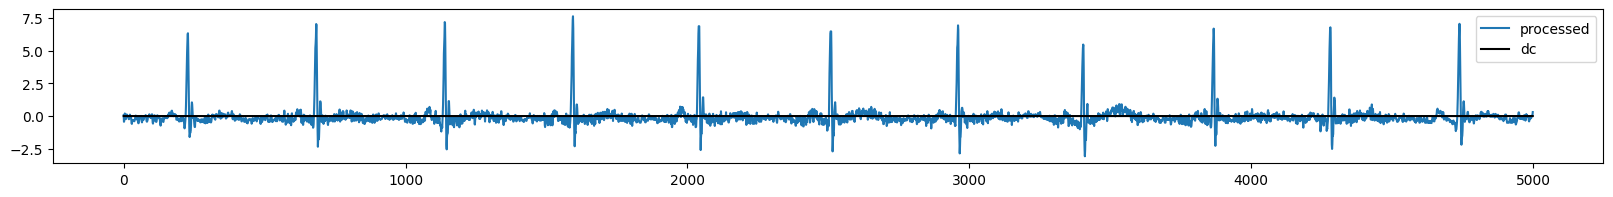

In [ ]:
subject = 1755
channel = 5

plt.figure(figsize=(20, 2))
plt.plot(dataset_ecgs[subject, channel], color='tab:blue', label='processed')
plt.plot(np.zeros(5000), color='black', label='dc')
plt.legend()
plt.show()

## TEXT MODEL

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1) #.expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Sentences we want sentence embeddings for
sentences = ["Here is in image: Cat scratch injury", "Cat scratch disease hi", "Bartonellosis"]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', output_hidden_states=False)

max_position_embeddings = 384

# # Tokenize sentences
# encoded_input = tokenizer(sentences, 
#                           padding='max_length', 
#                           max_length=max_position_embeddings, 
#                           truncation=True, 
#                           return_tensors='pt')

# # Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)

# # Perform pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# # Normalize embeddings
# sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

/home/oturgut/miniconda3/envs/mmcl3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Remove datapoints with empty reports

In [ ]:
text_data = torch.load("/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_train_20k.pt") 
ecg_data = torch.load("/home/oturgut/data/processed/mimic-ecg-text/ecgs_train_20k.pt")

In [ ]:
len(text_data)

20480

In [ ]:
sentences = []
for text in text_data:
    sentences.extend(text)

print(len(sentences))

171970


In [ ]:
2520480*8/(1024*1024*1024)

0.01877903938293457

In [ ]:
empty_data = []
indices = []
new_text_data = []
for idx, text in enumerate(text_data):
    if not text:
        empty_data.append(idx)
        indices.append(False)
    else:
        new_text_data.append(text)
        indices.append(True)

In [ ]:
len(empty_data)

1138

In [ ]:
new_ecg_data = ecg_data[indices]

In [ ]:
# torch.save(new_text_data, "/home/oturgut/data/processed/mimic-ecg-text/radiology_reports_train_20k_clean.pt")
# torch.save(new_ecg_data, "/home/oturgut/data/processed/mimic-ecg-text/ecgs_train_20k_clean.pt")

Visualize data

In [ ]:
text_list = []
for sentences in text_data:
    for idx, sentence in enumerate(sentences):
        text_list.append(sentence)

In [ ]:
len(text_list)

1778604

In [ ]:
text_list = []
for sentences in text_data:
    text = ""
    for idx, sentence in enumerate(sentences):
        text += sentence
        if idx < len(sentences)-1:
            text += " "

    text_list.append(text)

In [ ]:
text_list[:10]

['AP upright and lateral views of the chest are obtained. There is mild elevation of the right hemidiaphragm with blunted right CP angle which could reflect a small effusion. Evaluation is overall limited given the low lung volumes, though there is no focal consolidation of overt CHF. Bony structures appear grossly intact. Degenerative spurring in the mid thoracic spine noted. Possible small right pleural effusion. No overt abnormalities including no definite pneumonia.',
 'AP upright and lateral views of the chest are obtained. There is mild elevation of the right hemidiaphragm with blunted right CP angle which could reflect a small effusion. Evaluation is overall limited given the low lung volumes, though there is no focal consolidation of overt CHF. Bony structures appear grossly intact. Degenerative spurring in the mid thoracic spine noted. Possible small right pleural effusion. No overt abnormalities including no definite pneumonia.',
 'AP upright and lateral views of the chest ar

In [ ]:
max_position_embeddings = 512
tokenized_sentences = tokenizer(text_list, 
                                # padding='max_length', 
                                # truncation=True, 
                                # max_length=max_position_embeddings, 
                                # return_tensors='pt'
                                )

In [ ]:
tokenized_sentences[:10]

[Encoding(num_tokens=107, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=107, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=107, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=73, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=2, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=18, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=19, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=87, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=167, attr

In [ ]:
text_len = np.array([enc.__len__() for enc in tokenized_sentences[:]])

In [ ]:
(text_len < 128).sum()

568379

<function matplotlib.pyplot.show(close=None, block=None)>

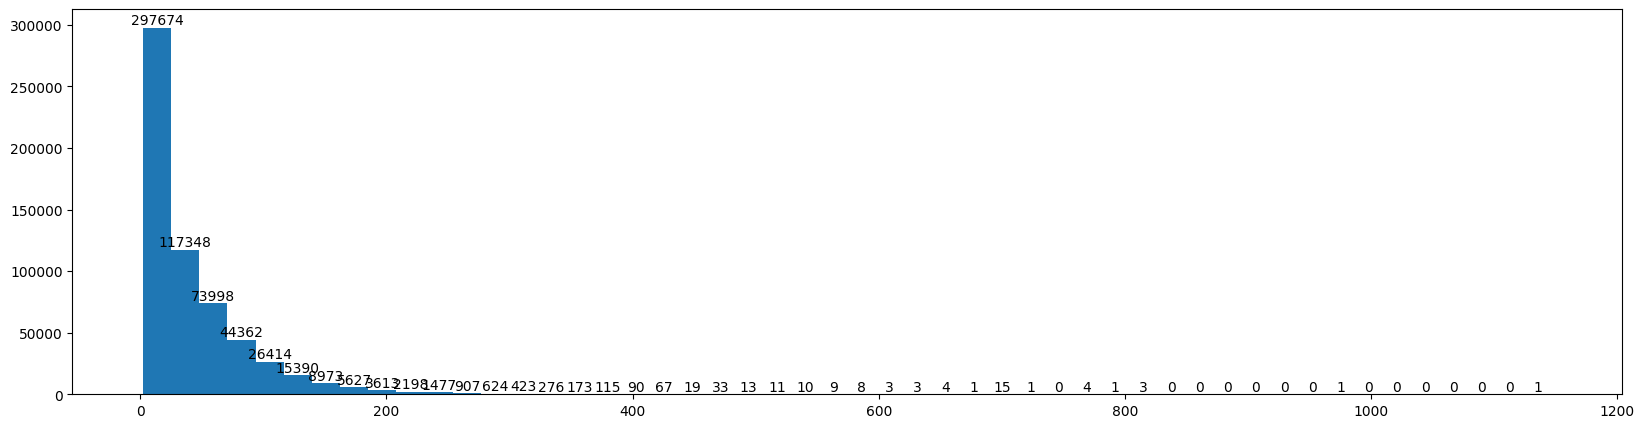

In [ ]:
plt.figure(figsize=(20, 5))
counts, edges, bars = plt.hist(text_len, bins=50)
plt.bar_label(bars)
plt.show

Play around

In [ ]:
text_orig = []
text_length = []
for text in text_data[:10]:
    text_orig.extend(text)
    text_length.append(len(text))

In [ ]:
text_length

[7, 7, 7, 6, 0, 2, 2, 6, 11, 11]

In [ ]:
text_orig

['AP upright and lateral views of the chest are obtained.',
 'There is mild elevation of the right hemidiaphragm with blunted right CP angle which could reflect a small effusion.',
 'Evaluation is overall limited given the low lung volumes, though there is no focal consolidation of overt CHF.',
 'Bony structures appear grossly intact.',
 'Degenerative spurring in the mid thoracic spine noted.',
 'Possible small right pleural effusion.',
 'No overt abnormalities including no definite pneumonia.',
 'AP upright and lateral views of the chest are obtained.',
 'There is mild elevation of the right hemidiaphragm with blunted right CP angle which could reflect a small effusion.',
 'Evaluation is overall limited given the low lung volumes, though there is no focal consolidation of overt CHF.',
 'Bony structures appear grossly intact.',
 'Degenerative spurring in the mid thoracic spine noted.',
 'Possible small right pleural effusion.',
 'No overt abnormalities including no definite pneumonia.'

In [ ]:
# Tokenize each sentence separately
encoded_input = tokenizer(text_orig, 
                          padding='longest', 
                        #   max_length=max_position_embeddings, 
                          truncation=True, 
                          return_tensors='pt')

In [ ]:
encoded_input

{'input_ids': tensor([[  101,   170,  1643,  ...,     0,     0,     0],
        [  101,  1175,  1110,  ..., 17268,   119,   102],
        [  101, 10540,  1110,  ...,     0,     0,     0],
        ...,
        [  101, 26600,  5048,  ...,     0,     0,     0],
        [  101, 20673,  1107,  ...,     0,     0,     0],
        [  101,  2812,  4455,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
print(encoded_input["input_ids"][0])
print(encoded_input["attention_mask"][0])

tensor([  101,   170,  1643, 10170,  1105, 11937,  4696,  1104,  1103,  2229,
         1132,  3836,   119,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])


In [ ]:
with torch.no_grad():
    model_output = model(**encoded_input)

In [ ]:
model_output["last_hidden_state"].shape

torch.Size([59, 31, 768])

In [ ]:
encoded_input["attention_mask"][0].unsqueeze(dim=-1).shape

torch.Size([31, 1])

In [ ]:
model_output["last_hidden_state"][0]

tensor([[ 0.2666, -0.0166,  0.4136,  ..., -0.1365,  0.2224,  0.0642],
        [ 0.0500, -0.0197,  0.4866,  ..., -0.0143,  0.4646,  0.1737],
        [-0.1082, -0.0245,  0.3287,  ...,  0.0341,  0.2271, -0.0101],
        ...,
        [ 0.1591, -0.4269,  0.2486,  ..., -0.1494, -0.0074,  0.3174],
        [ 0.1581, -0.1189,  0.1682,  ..., -0.0842,  0.0619,  0.3712],
        [ 0.0438, -0.1829,  0.0425,  ..., -0.1881,  0.1239,  0.2716]])

In [ ]:
masked_model_output = model_output["last_hidden_state"] * encoded_input["attention_mask"].unsqueeze(dim=-1)

In [ ]:
masked_model_output[0]

tensor([[ 0.2666, -0.0166,  0.4136,  ..., -0.1365,  0.2224,  0.0642],
        [ 0.0500, -0.0197,  0.4866,  ..., -0.0143,  0.4646,  0.1737],
        [-0.1082, -0.0245,  0.3287,  ...,  0.0341,  0.2271, -0.0101],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000]])

In [ ]:
def max_pooling(model_output, attention_mask, text_length):
      token_embeddings = model_output["last_hidden_state"] # Sequence of embeddings at the output of the last model layer
      input_mask = attention_mask.unsqueeze(-1)

      masked_token_embeddings = token_embeddings * input_mask

      pooled_token_embeddings = torch.max(masked_token_embeddings, dim=1)[0]

      return pooled_token_embeddings

In [ ]:
max_pooling(model_output, encoded_input["attention_mask"], None).shape

torch.Size([59, 768])

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1) #.expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
pooled_emb = mean_pooling(model_output, encoded_input["attention_mask"])

In [ ]:
pooled_emb.shape

torch.Size([59, 768])

In [ ]:
emb1 = pooled_emb[0:2].mean(dim=0, keepdim=True)
emb2 = pooled_emb[2:4].mean(dim=0, keepdim=True)
emb3 = pooled_emb[4:6].mean(dim=0, keepdim=True)

In [ ]:
my_list = [emb1, emb2, emb3]

In [ ]:
emb1.shape

torch.Size([1, 768])

In [ ]:
torch.cat(my_list, dim=0).shape

torch.Size([3, 768])

In [ ]:
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
sentence_embeddings.shape

torch.Size([3, 768])

In [ ]:
model

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0): MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_features

In [ ]:
for name, param in model.named_parameters():
    print(name)

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.attn.q.weight
encoder.layer.0.attention.attn.q.bias
encoder.layer.0.attention.attn.k.weight
encoder.layer.0.attention.attn.k.bias
encoder.layer.0.attention.attn.v.weight
encoder.layer.0.attention.attn.v.bias
encoder.layer.0.attention.attn.o.weight
encoder.layer.0.attention.attn.o.bias
encoder.layer.0.attention.LayerNorm.weight
encoder.layer.0.attention.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.attn.q.weight
encoder.layer.1.attention.attn.q.bias
encoder.layer.1.attention.attn.k.weight
encoder.layer.1.attention.attn.k.bias
encoder.layer.1.attention.attn.v.weight
encoder.layer.1.attention.attn.v.bias
encoder.layer.

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1) #.expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Sentences we want sentence embeddings for
sentences = [["Cat scratch injury", "Cat scratch disease hi"], ["Bartonellosis"]]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('FremyCompany/BioLORD-STAMB2-v1')
model = AutoModel.from_pretrained('FremyCompany/BioLORD-STAMB2-v1', output_hidden_states=False, output_attentions=False)

# Tokenize sentences
encoded_input = []
for sntc in sentences:
    tokenized_input = tokenizer(sntc, padding=True, truncation=True, return_tensors='pt')
    encoded_input.append(tokenized_input)

# Compute token embeddings
model_outputs = []
with torch.no_grad():
    for data_point in encoded_input:
        model_outputs.append(model(**data_point))

sentence_embeddings = []
for idx, model_output in enumerate(model_outputs):
    # Perform pooling
    sentence_embedding = mean_pooling(model_output, encoded_input[idx]['attention_mask'])
    # Normalize embeddings
    sentence_embedding = F.normalize(sentence_embedding, p=2, dim=1)
    sentence_embeddings.append(sentence_embedding)

# print("Sentence embeddings:")
# print(sentence_embeddings)

In [ ]:
encoded_input

[{'input_ids': tensor([[    0,  4941, 11973,  4548,     2,     1],
         [    0,  4941, 11973,  4299,  7636,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1]])},
 {'input_ids': tensor([[    0, 12979, 15354,  6194,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}]

In [ ]:
print(encoded_input[1]["input_ids"].shape)
print(encoded_input[1]["attention_mask"].shape)

torch.Size([1, 5])
torch.Size([1, 5])


In [ ]:
model_outputs[1]['last_hidden_state'].shape

torch.Size([1, 5, 768])

In [ ]:
model_output

[BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.0870,  0.0645,  0.0098,  ...,  0.0424, -0.0181,  0.1190],
          [ 0.0227,  0.2596,  0.0271,  ...,  0.1137, -0.0223,  0.0496],
          [ 0.0836,  0.0473, -0.0310,  ...,  0.1554, -0.0554,  0.1379],
          [-0.0267,  0.1297, -0.0454,  ...,  0.1109, -0.0114,  0.1192],
          [-0.0958,  0.0872,  0.0079,  ...,  0.0675,  0.0018,  0.1379],
          [-0.0861,  0.0774, -0.0070,  ...,  0.0501, -0.0143,  0.1292]],
 
         [[ 0.0284,  0.2059,  0.0289,  ...,  0.1025, -0.0290,  0.0381],
          [ 0.1187,  0.4395, -0.0072,  ...,  0.0496,  0.0509,  0.0447],
          [ 0.1225,  0.2441, -0.0607,  ...,  0.0828, -0.0102,  0.0117],
          [ 0.0516,  0.3985,  0.0582,  ...,  0.0559, -0.0555, -0.0151],
          [ 0.1033,  0.4640,  0.0588,  ...,  0.0649,  0.0380,  0.1025],
          [-0.0066,  0.1456,  0.0037,  ...,  0.1302, -0.0198,  0.0529]]]), pooler_output=tensor([[ 0.0536, -0.0376,  0.0206,  ...,  0.0074,  0.0521,  0.0498],
 

In [ ]:
print(model_output[0]['last_hidden_state'].shape)

torch.Size([2, 6, 768])


In [ ]:
model_output[0]['last_hidden_state']

tensor([[[-0.0870,  0.0645,  0.0098,  ...,  0.0424, -0.0181,  0.1190],
         [ 0.0227,  0.2596,  0.0271,  ...,  0.1137, -0.0223,  0.0496],
         [ 0.0836,  0.0473, -0.0310,  ...,  0.1554, -0.0554,  0.1379],
         [-0.0267,  0.1297, -0.0454,  ...,  0.1109, -0.0114,  0.1192],
         [-0.0958,  0.0872,  0.0079,  ...,  0.0675,  0.0018,  0.1379],
         [-0.0861,  0.0774, -0.0070,  ...,  0.0501, -0.0143,  0.1292]],

        [[ 0.0284,  0.2059,  0.0289,  ...,  0.1025, -0.0290,  0.0381],
         [ 0.1187,  0.4395, -0.0072,  ...,  0.0496,  0.0509,  0.0447],
         [ 0.1225,  0.2441, -0.0607,  ...,  0.0828, -0.0102,  0.0117],
         [ 0.0516,  0.3985,  0.0582,  ...,  0.0559, -0.0555, -0.0151],
         [ 0.1033,  0.4640,  0.0588,  ...,  0.0649,  0.0380,  0.1025],
         [-0.0066,  0.1456,  0.0037,  ...,  0.1302, -0.0198,  0.0529]]])

In [ ]:
print(encoded_input[0]["input_ids"])
print(encoded_input[0]["attention_mask"])

tensor([[    0,  4941, 11973,  4548,     2,     1],
        [    0,  4941, 11973,  4299,  7636,     2]])
tensor([[1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]])


In [ ]:
print(sentence_embeddings[0].shape)
print(sentence_embeddings[1].shape)

torch.Size([2, 768])
torch.Size([1, 768])


In [ ]:
sentence_embeddings[0]

tensor([[-0.0063,  0.0356, -0.0019,  ...,  0.0296, -0.0064,  0.0341],
        [ 0.0204,  0.0927,  0.0040,  ...,  0.0237, -0.0012,  0.0115]])

In [ ]:
sum(p.numel() for p in model.parameters()) # nb parameters

109486464